In [1]:
import torch
from covid_ode import sidartha_ode, covid_dataset
import pandas as pd
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
canada = pd.read_csv('canada.csv')
canada = canada.values[:, 0:3].astype(float)

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
canada.shape

(555, 3)

In [5]:
canada

array([[4.000000e+00, 0.000000e+00, 0.000000e+00],
       [4.000000e+00, 0.000000e+00, 0.000000e+00],
       [4.000000e+00, 0.000000e+00, 0.000000e+00],
       ...,
       [1.435683e+06, 1.404327e+06, 2.660200e+04],
       [1.437713e+06, 1.405529e+06, 2.660800e+04],
       [1.438806e+06, 1.405971e+06, 2.661900e+04]])

In [6]:
TRAIN_IDX = int(canada.shape[0]*.5)
VAL_IDX = TRAIN_IDX + int(canada.shape[0]*.1)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(canada[:TRAIN_IDX])

MinMaxScaler()

In [7]:
canada_train = min_max_scaler.transform(canada[:TRAIN_IDX])
canada_val = min_max_scaler.transform(canada[TRAIN_IDX:VAL_IDX])
canada_test = min_max_scaler.transform(canada[VAL_IDX:])

In [8]:
# Learning Rate
lr = 0.0001

# number of historic data points for fitting
input_steps = 1

# forecasting horizon
output_steps = 2

# number of epochs for training
num_epochs = 50
num_epochs_for_test = 3

In [9]:
VAL_IDX-TRAIN_IDX

55

In [10]:
training_data = covid_dataset.CovidDataset(canada_train, input_steps, output_steps)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)

val_data = covid_dataset.CovidDataset(canada_val, input_steps, output_steps)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

test_data = covid_dataset.CovidDataset(canada_test, input_steps, output_steps)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [11]:
def train(dataloader, limit=None):
    for i, data_with_exact in tqdm(enumerate(dataloader), total=limit if limit else len(train_dataloader)):
        losses = 0
        data, y_exact = data_with_exact
        optimizer.zero_grad()    
        y_approx = model(I0=data[0,0,0], H0=data[0,0,1], E0=data[0,0,2])
        loss = loss_fun(y_approx[1:, 
                                 [model.pos_dict['I'], model.pos_dict['H'], model.pos_dict['E']]], # I, H, E
                        y_exact.squeeze())
        loss.backward()
        losses += loss
        optimizer.step()
        scheduler.step()
        with torch.no_grad():
            state_dict = model.state_dict()
            for k in state_dict.keys():
                state_dict[k] = torch.clamp(state_dict[k], min=1e-2)
            model.load_state_dict(state_dict)
        if limit and i == limit:
            break
    print("Train losses:", losses/i)

In [12]:
model = sidartha_ode.SIDARTHEOde(len_data = output_steps).to(device)

torch.manual_seed(3407)
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1000, gamma=0.9)
loss_fun = torch.nn.MSELoss()

for _ in range(num_epochs):
    train(train_dataloader)
    if (_ % 10) == 0:
        validation_prediction = []
        with torch.no_grad():
            val_losses = 0
            for data, y_exact in val_dataloader:
                y_approx = model(I0=data[0,0,0], H0=data[0,0,1], E0=data[0,0,2])
                validation_prediction.append(y_approx.numpy())
                loss = loss_fun(y_approx[1:, 
                                     [model.pos_dict['I'], model.pos_dict['H'], model.pos_dict['E']]], # I, H, E
                            y_exact.squeeze())
                val_losses += loss
            print("Val losses: ", val_losses/len(val_data))

  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.7302e-05, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0515)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.7347e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.6288e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.4721e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.2239e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.9729e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.7327e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.5424e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.3604e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.2012e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.0962e-05, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0235)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(1.0121e-05, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(9.3741e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(8.6968e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(8.2593e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(7.7216e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(7.2267e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(6.7675e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(6.4128e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(6.0866e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(5.7568e-06, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0146)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(5.5641e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(5.2723e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(5.0039e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.7530e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.5936e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.3950e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.2035e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(4.0207e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.8750e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.7515e-06, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0107)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.6177e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.5670e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.4329e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.3126e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.2007e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.1244e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(3.0435e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.9599e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.8772e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.8063e-06, grad_fn=<DivBackward0>)
Val losses:  tensor(0.0087)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.7543e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.6942e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.6816e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.6170e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.5583e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.5033e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.4592e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.4248e-06, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(2.3862e-06, grad_fn=<DivBackward0>)


In [13]:
# predict, confirmed, recovered, death
validation_prediction = np.array(validation_prediction)
observerable=[validation_prediction[:, :, [model.pos_dict['I'], model.pos_dict['H'], model.pos_dict['E']]]]

In [14]:
inversed_predict = [min_max_scaler.inverse_transform(i) for i in observerable[0]]

In [15]:
inversed_predict = np.array(inversed_predict)

In [16]:
predict_1_ahead = inversed_predict[:,1]
predict_2_ahead = inversed_predict[:,2]

In [17]:
true_value=min_max_scaler.inverse_transform(canada_val)

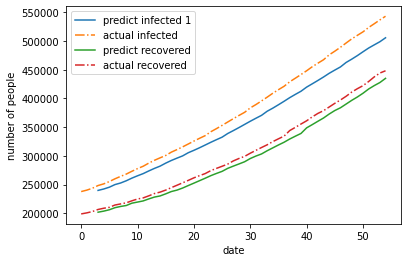

In [18]:
import matplotlib.pyplot as plt

x = range(len(true_value))

plt.plot(x[3:], predict_1_ahead[:,0], label ='predict infected 1')
plt.plot(x, true_value[:,0], '-.', label ='actual infected')
plt.plot(x[3:], predict_1_ahead[:,1], label ='predict recovered')
plt.plot(x, true_value[:,1], '-.', label ='actual recovered')

plt.xlabel("date")
plt.ylabel("number of people")
plt.legend()
plt.show()

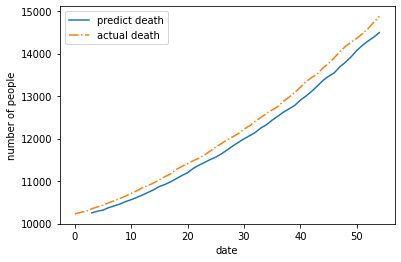

In [19]:
plt.plot(x[3:], predict_1_ahead[:,2], label ='predict death')
plt.plot(x, true_value[:,2], '-.', label ='actual death')
plt.xlabel("date")
plt.ylabel("number of people")
plt.legend()
plt.show()

In [20]:
mean_squared_error(predict_1_ahead[:,0], true_value[3:,0], squared=False)

24133.92407789865

In [21]:
mean_squared_error(predict_1_ahead[:,1], true_value[3:,1], squared=False)

10459.100766037422

In [22]:
mean_squared_error(predict_1_ahead[:,2], true_value[3:,2], squared=False)

244.40168377022533

In [23]:
list(model.named_parameters())

[('y0',
  Parameter containing:
  tensor([0.4184, 0.0737, 0.1120, 0.0681, 0.0487], requires_grad=True)),
 ('α',
  Parameter containing:
  tensor([0.4772], requires_grad=True)),
 ('β',
  Parameter containing:
  tensor([0.0109], requires_grad=True)),
 ('γ',
  Parameter containing:
  tensor([0.1268], requires_grad=True)),
 ('δ',
  Parameter containing:
  tensor([0.0107], requires_grad=True)),
 ('ε',
  Parameter containing:
  tensor([0.0950], requires_grad=True)),
 ('θ',
  Parameter containing:
  tensor([0.6212], requires_grad=True)),
 ('ζ',
  Parameter containing:
  tensor([0.0472], requires_grad=True)),
 ('η',
  Parameter containing:
  tensor([0.1879], requires_grad=True)),
 ('μ',
  Parameter containing:
  tensor([0.2550], requires_grad=True)),
 ('ν',
  Parameter containing:
  tensor([0.1511], requires_grad=True)),
 ('τ',
  Parameter containing:
  tensor([0.0382], requires_grad=True)),
 ('λ',
  Parameter containing:
  tensor([0.0100], requires_grad=True)),
 ('κ',
  Parameter containing:


### Predict whole test set

In [24]:
train(val_dataloader, limit=len(val_dataloader))

  0%|          | 0/52 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


In [25]:
test_prediction = []
for i, data_and_output in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    data, _ = data_and_output
    # use test set to retrain model
    if i % (output_steps+input_steps) == 0 and i > 0:
        print("Retrain on past test")
        for epoch in range(num_epochs_for_test):
            train(test_dataloader, limit=i-output_steps-1)  # only train on 1-output_steps-1 sample
    # predict
    with torch.no_grad():
        y_approx = model(I0=data[0,0,0], H0=data[0,0,1], E0=data[0,0,2])
        test_prediction.append(y_approx[1:,
                                        [model.pos_dict['I'], model.pos_dict['H'], model.pos_dict['E']]].detach().numpy())

  0%|          | 0/220 [00:00<?, ?it/s]

Retrain on past test


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(0.0025, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(0.0020, grad_fn=<DivBackward0>)


  0%|          | 0/274 [00:00<?, ?it/s]

Train losses: tensor(0.0016, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/3 [00:00<?, ?it/s]

Train losses: tensor(0.0005, grad_fn=<DivBackward0>)


  0%|          | 0/3 [00:00<?, ?it/s]

Train losses: tensor(0.0005, grad_fn=<DivBackward0>)


  0%|          | 0/3 [00:00<?, ?it/s]

Train losses: tensor(0.0005, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/6 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/6 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/6 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/9 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/9 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/9 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/12 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/12 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/12 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/15 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/15 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/15 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/18 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/18 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/18 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/21 [00:00<?, ?it/s]

Train losses: tensor(8.1478e-05, grad_fn=<DivBackward0>)


  0%|          | 0/21 [00:00<?, ?it/s]

Train losses: tensor(8.1351e-05, grad_fn=<DivBackward0>)


  0%|          | 0/21 [00:00<?, ?it/s]

Train losses: tensor(8.1223e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/24 [00:00<?, ?it/s]

Train losses: tensor(8.4396e-05, grad_fn=<DivBackward0>)


  0%|          | 0/24 [00:00<?, ?it/s]

Train losses: tensor(8.4185e-05, grad_fn=<DivBackward0>)


  0%|          | 0/24 [00:00<?, ?it/s]

Train losses: tensor(8.3974e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/27 [00:00<?, ?it/s]

Train losses: tensor(7.5647e-05, grad_fn=<DivBackward0>)


  0%|          | 0/27 [00:00<?, ?it/s]

Train losses: tensor(7.5470e-05, grad_fn=<DivBackward0>)


  0%|          | 0/27 [00:00<?, ?it/s]

Train losses: tensor(7.5292e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/30 [00:00<?, ?it/s]

Train losses: tensor(7.0460e-05, grad_fn=<DivBackward0>)


  0%|          | 0/30 [00:00<?, ?it/s]

Train losses: tensor(7.0243e-05, grad_fn=<DivBackward0>)


  0%|          | 0/30 [00:00<?, ?it/s]

Train losses: tensor(7.0026e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/33 [00:00<?, ?it/s]

Train losses: tensor(7.3826e-05, grad_fn=<DivBackward0>)


  0%|          | 0/33 [00:00<?, ?it/s]

Train losses: tensor(7.3563e-05, grad_fn=<DivBackward0>)


  0%|          | 0/33 [00:00<?, ?it/s]

Train losses: tensor(7.3322e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/36 [00:00<?, ?it/s]

Train losses: tensor(6.3277e-05, grad_fn=<DivBackward0>)


  0%|          | 0/36 [00:00<?, ?it/s]

Train losses: tensor(6.3059e-05, grad_fn=<DivBackward0>)


  0%|          | 0/36 [00:00<?, ?it/s]

Train losses: tensor(6.2840e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/39 [00:00<?, ?it/s]

Train losses: tensor(6.8850e-05, grad_fn=<DivBackward0>)


  0%|          | 0/39 [00:00<?, ?it/s]

Train losses: tensor(6.8545e-05, grad_fn=<DivBackward0>)


  0%|          | 0/39 [00:00<?, ?it/s]

Train losses: tensor(6.8239e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/42 [00:00<?, ?it/s]

Train losses: tensor(6.2792e-05, grad_fn=<DivBackward0>)


  0%|          | 0/42 [00:00<?, ?it/s]

Train losses: tensor(6.2465e-05, grad_fn=<DivBackward0>)


  0%|          | 0/42 [00:00<?, ?it/s]

Train losses: tensor(6.2137e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/45 [00:00<?, ?it/s]

Train losses: tensor(6.1221e-05, grad_fn=<DivBackward0>)


  0%|          | 0/45 [00:00<?, ?it/s]

Train losses: tensor(6.0830e-05, grad_fn=<DivBackward0>)


  0%|          | 0/45 [00:00<?, ?it/s]

Train losses: tensor(6.0440e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/48 [00:00<?, ?it/s]

Train losses: tensor(6.2867e-05, grad_fn=<DivBackward0>)


  0%|          | 0/48 [00:00<?, ?it/s]

Train losses: tensor(6.2391e-05, grad_fn=<DivBackward0>)


  0%|          | 0/48 [00:00<?, ?it/s]

Train losses: tensor(6.1918e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/51 [00:00<?, ?it/s]

Train losses: tensor(5.5705e-05, grad_fn=<DivBackward0>)


  0%|          | 0/51 [00:00<?, ?it/s]

Train losses: tensor(5.5194e-05, grad_fn=<DivBackward0>)


  0%|          | 0/51 [00:00<?, ?it/s]

Train losses: tensor(5.4686e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/54 [00:00<?, ?it/s]

Train losses: tensor(5.7638e-05, grad_fn=<DivBackward0>)


  0%|          | 0/54 [00:00<?, ?it/s]

Train losses: tensor(5.6981e-05, grad_fn=<DivBackward0>)


  0%|          | 0/54 [00:00<?, ?it/s]

Train losses: tensor(5.6338e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/57 [00:00<?, ?it/s]

Train losses: tensor(5.6955e-05, grad_fn=<DivBackward0>)


  0%|          | 0/57 [00:00<?, ?it/s]

Train losses: tensor(5.6334e-05, grad_fn=<DivBackward0>)


  0%|          | 0/57 [00:00<?, ?it/s]

Train losses: tensor(5.5740e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/60 [00:00<?, ?it/s]

Train losses: tensor(5.5333e-05, grad_fn=<DivBackward0>)


  0%|          | 0/60 [00:00<?, ?it/s]

Train losses: tensor(5.4650e-05, grad_fn=<DivBackward0>)


  0%|          | 0/60 [00:00<?, ?it/s]

Train losses: tensor(5.3976e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/63 [00:00<?, ?it/s]

Train losses: tensor(5.2361e-05, grad_fn=<DivBackward0>)


  0%|          | 0/63 [00:00<?, ?it/s]

Train losses: tensor(5.1669e-05, grad_fn=<DivBackward0>)


  0%|          | 0/63 [00:00<?, ?it/s]

Train losses: tensor(5.0990e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/66 [00:00<?, ?it/s]

Train losses: tensor(5.1636e-05, grad_fn=<DivBackward0>)


  0%|          | 0/66 [00:00<?, ?it/s]

Train losses: tensor(5.0818e-05, grad_fn=<DivBackward0>)


  0%|          | 0/66 [00:00<?, ?it/s]

Train losses: tensor(5.0018e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/69 [00:00<?, ?it/s]

Train losses: tensor(5.0434e-05, grad_fn=<DivBackward0>)


  0%|          | 0/69 [00:00<?, ?it/s]

Train losses: tensor(4.9534e-05, grad_fn=<DivBackward0>)


  0%|          | 0/69 [00:00<?, ?it/s]

Train losses: tensor(4.8660e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/72 [00:00<?, ?it/s]

Train losses: tensor(4.7671e-05, grad_fn=<DivBackward0>)


  0%|          | 0/72 [00:00<?, ?it/s]

Train losses: tensor(4.6765e-05, grad_fn=<DivBackward0>)


  0%|          | 0/72 [00:00<?, ?it/s]

Train losses: tensor(4.5887e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/75 [00:00<?, ?it/s]

Train losses: tensor(4.9502e-05, grad_fn=<DivBackward0>)


  0%|          | 0/75 [00:00<?, ?it/s]

Train losses: tensor(4.8509e-05, grad_fn=<DivBackward0>)


  0%|          | 0/75 [00:00<?, ?it/s]

Train losses: tensor(4.7555e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/78 [00:00<?, ?it/s]

Train losses: tensor(4.6049e-05, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

Train losses: tensor(4.5051e-05, grad_fn=<DivBackward0>)


  0%|          | 0/78 [00:00<?, ?it/s]

Train losses: tensor(4.4102e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/81 [00:00<?, ?it/s]

Train losses: tensor(4.6518e-05, grad_fn=<DivBackward0>)


  0%|          | 0/81 [00:00<?, ?it/s]

Train losses: tensor(4.5402e-05, grad_fn=<DivBackward0>)


  0%|          | 0/81 [00:00<?, ?it/s]

Train losses: tensor(4.4353e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/84 [00:00<?, ?it/s]

Train losses: tensor(4.4551e-05, grad_fn=<DivBackward0>)


  0%|          | 0/84 [00:00<?, ?it/s]

Train losses: tensor(4.3526e-05, grad_fn=<DivBackward0>)


  0%|          | 0/84 [00:00<?, ?it/s]

Train losses: tensor(4.2589e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/87 [00:00<?, ?it/s]

Train losses: tensor(4.7831e-05, grad_fn=<DivBackward0>)


  0%|          | 0/87 [00:00<?, ?it/s]

Train losses: tensor(4.6666e-05, grad_fn=<DivBackward0>)


  0%|          | 0/87 [00:00<?, ?it/s]

Train losses: tensor(4.5587e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/90 [00:00<?, ?it/s]

Train losses: tensor(4.8514e-05, grad_fn=<DivBackward0>)


  0%|          | 0/90 [00:00<?, ?it/s]

Train losses: tensor(4.7216e-05, grad_fn=<DivBackward0>)


  0%|          | 0/90 [00:00<?, ?it/s]

Train losses: tensor(4.6032e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/93 [00:00<?, ?it/s]

Train losses: tensor(5.1701e-05, grad_fn=<DivBackward0>)


  0%|          | 0/93 [00:00<?, ?it/s]

Train losses: tensor(5.0256e-05, grad_fn=<DivBackward0>)


  0%|          | 0/93 [00:00<?, ?it/s]

Train losses: tensor(4.8959e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/96 [00:00<?, ?it/s]

Train losses: tensor(5.4207e-05, grad_fn=<DivBackward0>)


  0%|          | 0/96 [00:00<?, ?it/s]

Train losses: tensor(5.2837e-05, grad_fn=<DivBackward0>)


  0%|          | 0/96 [00:00<?, ?it/s]

Train losses: tensor(5.1612e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/99 [00:00<?, ?it/s]

Train losses: tensor(5.6653e-05, grad_fn=<DivBackward0>)


  0%|          | 0/99 [00:00<?, ?it/s]

Train losses: tensor(5.5195e-05, grad_fn=<DivBackward0>)


  0%|          | 0/99 [00:00<?, ?it/s]

Train losses: tensor(5.3915e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/102 [00:00<?, ?it/s]

Train losses: tensor(7.3671e-05, grad_fn=<DivBackward0>)


  0%|          | 0/102 [00:00<?, ?it/s]

Train losses: tensor(7.1709e-05, grad_fn=<DivBackward0>)


  0%|          | 0/102 [00:00<?, ?it/s]

Train losses: tensor(7.0017e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/105 [00:00<?, ?it/s]

Train losses: tensor(7.9602e-05, grad_fn=<DivBackward0>)


  0%|          | 0/105 [00:00<?, ?it/s]

Train losses: tensor(7.7592e-05, grad_fn=<DivBackward0>)


  0%|          | 0/105 [00:00<?, ?it/s]

Train losses: tensor(7.5936e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/108 [00:00<?, ?it/s]

Train losses: tensor(9.6714e-05, grad_fn=<DivBackward0>)


  0%|          | 0/108 [00:00<?, ?it/s]

Train losses: tensor(9.4360e-05, grad_fn=<DivBackward0>)


  0%|          | 0/108 [00:00<?, ?it/s]

Train losses: tensor(9.2340e-05, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/111 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/111 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/111 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/114 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/114 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/114 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/117 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/117 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/117 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/120 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/120 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/120 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/123 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/123 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/123 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/126 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/126 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/126 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/129 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/129 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/129 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/132 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/132 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/132 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/135 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/135 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/135 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/138 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/138 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/138 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/141 [00:00<?, ?it/s]

Train losses: tensor(0.0004, grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/141 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/144 [00:00<?, ?it/s]

Train losses: tensor(0.0004, grad_fn=<DivBackward0>)


  0%|          | 0/144 [00:00<?, ?it/s]

Train losses: tensor(0.0004, grad_fn=<DivBackward0>)


  0%|          | 0/144 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/147 [00:00<?, ?it/s]

Train losses: tensor(0.0004, grad_fn=<DivBackward0>)


  0%|          | 0/147 [00:00<?, ?it/s]

Train losses: tensor(0.0004, grad_fn=<DivBackward0>)


  0%|          | 0/147 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/150 [00:00<?, ?it/s]

Train losses: tensor(0.0004, grad_fn=<DivBackward0>)


  0%|          | 0/150 [00:00<?, ?it/s]

Train losses: tensor(0.0004, grad_fn=<DivBackward0>)


  0%|          | 0/150 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/153 [00:00<?, ?it/s]

Train losses: tensor(0.0004, grad_fn=<DivBackward0>)


  0%|          | 0/153 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/153 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/156 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/156 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/156 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/159 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/159 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/159 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/162 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/162 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/162 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/165 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/165 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/165 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/168 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/168 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/168 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/171 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/171 [00:00<?, ?it/s]

Train losses: tensor(0.0003, grad_fn=<DivBackward0>)


  0%|          | 0/171 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/174 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/174 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/174 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/177 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/177 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/177 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/180 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/180 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/180 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/183 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/183 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/183 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/186 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/186 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/186 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/189 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/189 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/189 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/192 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/192 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/192 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/195 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/195 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)


  0%|          | 0/195 [00:00<?, ?it/s]

Train losses: tensor(0.0002, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/198 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/198 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/198 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/201 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/201 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/201 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/204 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/204 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/204 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/207 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/207 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/207 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/210 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/210 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/210 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/213 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/213 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/213 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)
Retrain on past test


  0%|          | 0/216 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/216 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


  0%|          | 0/216 [00:00<?, ?it/s]

Train losses: tensor(0.0001, grad_fn=<DivBackward0>)


In [26]:
# test_prediction

In [27]:
test_prediction = np.array(test_prediction)

In [28]:
predict_1_day_ahead = test_prediction[:,0]

In [29]:
predict_1_day_ahead_observable=min_max_scaler.inverse_transform(
    predict_1_day_ahead                                                               )

In [30]:
true_test_value = min_max_scaler.inverse_transform(canada_test)

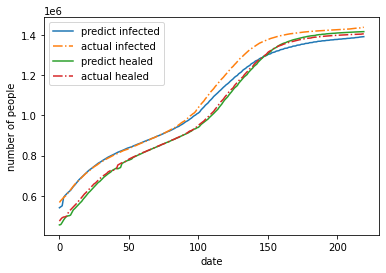

In [31]:
x =range(len(test_data))

plt.plot(x, predict_1_day_ahead_observable[:,0], label ='predict infected')
plt.plot(x, true_test_value[3:,0], '-.', label ='actual infected')
plt.plot(x, predict_1_day_ahead_observable[:,1], label ='predict healed')
plt.plot(x, true_test_value[3:,1], '-.', label ='actual healed')
plt.xlabel("date")
plt.ylabel("number of people")
plt.legend()
plt.show()

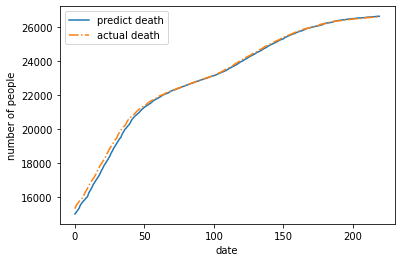

In [32]:
x =range(len(test_data))

plt.plot(x, predict_1_day_ahead_observable[:,2], label ='predict death')
plt.plot(x, true_test_value[3:,2], '-.', label ='actual death')
plt.xlabel("date")
plt.ylabel("number of people")
plt.legend()
plt.show()

In [33]:
data

tensor([[[6.0944, 7.1305, 2.6118]]])

In [34]:
list(model.named_parameters())

[('y0',
  Parameter containing:
  tensor([0.3609, 0.0100, 0.0308, 0.0100, 0.0410], requires_grad=True)),
 ('α',
  Parameter containing:
  tensor([0.4044], requires_grad=True)),
 ('β',
  Parameter containing:
  tensor([0.0100], requires_grad=True)),
 ('γ',
  Parameter containing:
  tensor([0.0571], requires_grad=True)),
 ('δ',
  Parameter containing:
  tensor([0.0100], requires_grad=True)),
 ('ε',
  Parameter containing:
  tensor([0.0100], requires_grad=True)),
 ('θ',
  Parameter containing:
  tensor([0.6860], requires_grad=True)),
 ('ζ',
  Parameter containing:
  tensor([0.0100], requires_grad=True)),
 ('η',
  Parameter containing:
  tensor([0.2510], requires_grad=True)),
 ('μ',
  Parameter containing:
  tensor([0.3246], requires_grad=True)),
 ('ν',
  Parameter containing:
  tensor([0.2138], requires_grad=True)),
 ('τ',
  Parameter containing:
  tensor([0.0961], requires_grad=True)),
 ('λ',
  Parameter containing:
  tensor([0.0100], requires_grad=True)),
 ('κ',
  Parameter containing:


In [35]:
mean_squared_error(predict_1_day_ahead_observable[:,0], true_test_value[3:,0], squared=False)

43856.8244393258

In [36]:
mean_squared_error(predict_1_day_ahead_observable[:,1], true_test_value[3:,1], squared=False)

10282.986681423245

In [37]:
mean_squared_error(predict_1_day_ahead_observable[:,2], true_test_value[3:,2], squared=False)

172.15617086297394